In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from astropy.io import fits
import ultranest
from ultranest.plot import cornerplot

In [2]:
# Get haslam map and use it to generate sky temperature cube in 10-100 MHz
def map_remazeilles_408MHz(map_file, galactic_coord_file):

    '''

    This function will return the Haslam map reprocessd by Remazeilles et al. (2014) in NESTED Galactic Coordinates. But the input data is in RING coordinates.

    This version is only destriped, not desourced.

    Example of input data:
    ----------------------
    map_file            = edges_folder + '/sky_models/haslam_map/haslam408_ds_Remazeilles2014.fits'
    galactic_coord_file = edges_folder + '/sky_models/coordinate_maps/pixel_coords_map_ring_galactic_res9.fits'


    '''


    # Loading NESTED galactic coordinates
    # -----------------------------------
    coord              = fits.open(galactic_coord_file)
    coord_array        = coord[1].data
    lon_ring           = coord_array['LONGITUDE']
    lat_ring           = coord_array['LATITUDE']

    lon = hp.reorder(lon_ring, r2n=True)
    lat = hp.reorder(lat_ring, r2n=True)
 

    # GALAC_COORD_object = apc.SkyCoord(lon, lat, frame='galactic', unit='deg')  # defaults to ICRS frame



    # Loading Haslam map
    # ------------------
    haslam_map = fits.open(map_file)
    x  = (haslam_map[1].data)['temperature']
    haslam408_ring = x.flatten()

    haslam408 = hp.reorder(haslam408_ring, r2n=True)


    print('REMAZEILLES 408MHz MAP')


    return haslam408, lon, lat

map_file = "haslam408_ds_Remazeilles2014.fits"
galactic_coord_file = "pixel_coords_map_ring_galactic_res9.fits"
hl, long, lat = map_remazeilles_408MHz(map_file,galactic_coord_file)

nu = np.arange(10,101,1)
real_map = np.array([hl*(10/408)**(-2.5)])
for i in np.arange(11,101,1):
    real_map = np.vstack([real_map,hl*(i/408)**(-2.5)])


REMAZEILLES 408MHz MAP


In [3]:
pmlong = long
for i in range(len(long)):
    if long[i] <= 360 and long[i] >= 180:
        pmlong[i] = long[i] - 360

In [4]:
reduce_map = hp.pixelfunc.ud_grade(real_map, 2**8,order_in = 'NESTED', order_out = 'NESTED')

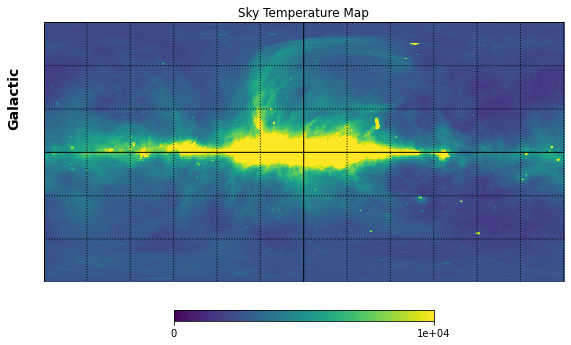

In [5]:
# At 50Mhz, the sky temperature map
hp.cartview(reduce_map[49], 
    title="Sky Temperature Map",
           nest=True,
           min=0,
    max=1e4, coord=["G", "G"])
hp.graticule()

In [6]:
reduce_long = hp.pixelfunc.ud_grade(long, 2**8, order_in = 'NESTED', order_out = 'NESTED')
reduce_lat = hp.pixelfunc.ud_grade(lat, 2**8, order_in = 'NESTED', order_out = 'NESTED')

In [7]:
# Generate 2D Gaussian Beam Cube plane
freq = np.array(range(10,101))
x0 = 0
y0 = 0
slope = 0.3
intercept = 7.5
sigx = slope * freq + intercept
sigy = sigx

In [8]:
# Convolution to generate curve
def reduce_convolution(slope, intercept, sky):
    x = np.ones(91)
    for i in range(91):
        sig = slope * freq + intercept
        lat_ = np.exp(-(reduce_lat**2/(2*(sig[i]**2))))
        long_ = np.exp((-reduce_long**2/(2*sig[i]**2)))
        bc = lat_*long_* 5
        x[i] = np.sum(bc*sky[i])/np.sum(bc)
    return x

In [9]:
curve2 = np.array([1521828.        , 1177627.75      ,  930878.0625    ,
        749137.25      ,  612178.5625    ,  506921.53125   ,
        424639.71875   ,  359352.40625   ,  306863.3125    ,
        264166.625     ,  229069.21875   ,  199944.8125    ,
        175568.96875   ,  155008.140625  ,  137541.203125  ,
        122605.5078125 ,  109757.0234375 ,   98642.5546875 ,
         88978.3515625 ,   80534.8203125 ,   73124.8515625 ,
         66594.6640625 ,   60817.32421875,   55687.25      ,
         51116.25390625,   47030.125     ,   43366.2265625 ,
         40071.421875  ,   37100.3984375 ,   34414.36328125,
         31979.97070312,   29768.48242188,   27754.984375  ,
         25917.85742188,   24238.25390625,   22699.66210938,
         21287.66015625,   19989.50195312,   18794.0078125 ,
         17691.24023438,   16672.41210938,   15729.73730469,
         14856.25585938,   14045.75488281,   13292.68945312,
         12592.09375   ,   11939.49609375,   11330.87109375,
         10762.60351562,   10231.41503906,    9734.36621094,
          9268.75976562,    8832.16796875,    8422.375     ,
          8037.37597656,    7675.33789062,    7334.57275391,
          7013.56591797,    6710.90869141,    6425.31933594,
          6155.61621094,    5900.72460938,    5659.64501953,
          5431.45849609,    5215.31933594,    5010.45556641,
          4816.13964844,    4631.70947266,    4456.54833984,
          4290.08496094,    4131.78808594,    3981.16992188,
          3837.76855469,    3701.16162109,    3570.95703125,
          3446.78100586,    3328.29467773,    3215.17700195,
          3107.12719727,    3003.86694336,    2905.13623047,
          2810.69165039,    2720.29956055,    2633.75390625,
          2550.8449707 ,    2471.38891602,    2395.20898438,
          2322.13574219,    2252.01635742,    2184.7019043 ,
          2120.05395508])

In [10]:
data2 = np.array([1522305.65929298, 1178392.15425227,  931097.55570173,
        749544.41237448,  612106.11075502,  507281.29641468,
        424986.45616128,  359242.88275039,  307317.22188097,
        264168.20829108,  229055.67323941,  200036.47915006,
        176012.40822268,  155012.68863487,  137341.0101817 ,
        122474.60511545,  109719.95900955,   98581.63226801,
         89175.68133965,   80476.03627696,   73052.41263333,
         66613.74752099,   60733.90859885,   55690.66844818,
         51138.49573402,   47058.18918081,   43468.53240536,
         39986.34949092,   37134.64979614,   34427.84718379,
         31929.24977925,   29744.79816882,   27775.32940046,
         25891.69955893,   24283.46738974,   22642.71825971,
         21286.69688962,   19971.08315982,   18787.87418433,
         17686.82042842,   16698.29381416,   15757.59255858,
         14838.56621446,   14052.72053781,   13286.72841287,
         12579.24233738,   11923.92560924,   11327.53125922,
         10750.51436478,   10235.06098101,    9738.70237062,
          9284.24474169,    8824.88959635,    8435.05945047,
          8039.61738358,    7680.54863413,    7346.6452677 ,
          7010.62676669,    6709.34829885,    6421.03527534,
          6148.77448157,    5896.60255528,    5655.8459036 ,
          5425.76883556,    5215.71452223,    5008.74969684,
          4821.46780572,    4628.81425878,    4452.13588996,
          4289.26880136,    4131.89921804,    3979.66249912,
          3841.25663577,    3704.33985971,    3566.86318372,
          3448.05438018,    3327.70766342,    3214.36879576,
          3115.49627169,    3006.11589069,    2904.5653562 ,
          2808.81015304,    2715.92487785,    2629.40769526,
          2550.34810168,    2470.04896858,    2393.33907205,
          2318.4586807 ,    2247.96665271,    2188.49136214,
          2121.95561157])

In [12]:
dt = 1
dnu = 1e6
sigma2 = curve2/np.sqrt(dnu*dt)

In [13]:
# Define model to simulate data
def model2(paras, nu):
    slope,intercept = paras
    return reduce_convolution(slope, intercept, reduce_map)

In [14]:
param_names = ['m', 'n']
def my_prior_transform(cube):
    params = cube.copy()

    # transform location parameter: uniform prior
    lo = 0
    hi = 1
    params[0] = cube[0] * (hi - lo) + lo

    # transform amplitude parameter: log-uniform prior
    lo = 5
    hi = 10
    params[1] = cube[1] * (hi - lo) + lo

    return params
def my_likelihood(params):
    mo = model2(params, nu)
    diff = mo - data2
    return -0.5 * np.sum((diff/sigma2)**2)

In [15]:
sampler = ultranest.ReactiveNestedSampler(param_names, my_likelihood, my_prior_transform)

In [17]:
result = sampler.run(min_num_live_points=200)
sampler.print_results()

[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-5e+01   [-51.2562..-51.2562]*| it/evals=3795/5939 eff=68.5142% N=200                    
[ultranest] Likelihood function evaluations: 5939
[ultranest]   logZ = -65.63 +- 0.2221
[ultranest] Effective samples strategy satisfied (ESS = 803.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.14 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 198 minimum live points (dlogz from 0.17 to 0.61, need <0.5)
[ultranest]   logZ error budget: single: 0.26 bs:0.22 tail:0.01 total:0.22 required:<0.50
[ultranest] done iterating.

logZ = -65.624 +- 0.523
  single instance: logZ = -65.624 +- 0.259
  bootstrapped   : logZ = -65.631 +- 0.523
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    m                   : 0.29972│ ▁▁▁▁▁▁▁▁▂▂▃▃▅▅▅▇▆▇▇▆▅▅▅▃▃▂▂▂▁▁▁▁▁▁ ▁▁ │0.30077    0.30021 +- 0.00014
    n                   : 7.4657│ ▁ ▁▁▁▁▁▁▁▁▁▂▂▃▃▆▃▆▇▆▆▇▆▅▅▄▄▂▁▂▁▁▁▁▁▁▁ │7.5131   

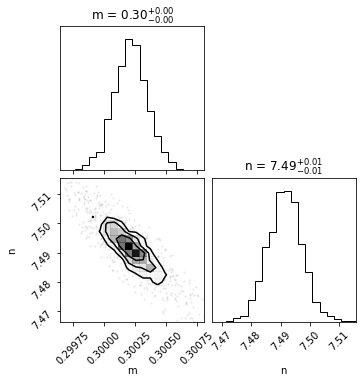

In [18]:
cornerplot(result)

In [19]:
result["samples"].shape

(3996, 2)

In [20]:
my_likelihood([0.3 , 7.5])

-52.53795072822256

In [21]:
my_likelihood([0.30021, 7.4914])

-51.25155846120281

In [22]:
- 1/2 * my_likelihood([0.30021, 7.4914]) + 2 * np.log(91)

34.647498243635106

In [23]:
np.savez("min_live_200", result)